# Train and evaluate the model

Build Deep Learning Regression Model with Sequential API and TF Probability Layers

In [2]:
import os
import numpy as np
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
from tensorflow.keras import layers
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import pandas as pd
import aequitas as ae

from sklearn.metrics import precision_score, recall_score, roc_auc_score, f1_score

from utils.utils import build_vocab_files, show_group_stats_viz, aggregate_dataset, preprocess_df, df_to_dataset, posterior_mean_field, prior_trainable
pd.set_option('display.max_columns', 500)

# this allows to make changes and save in student_utils.py and the file is reloaded every time you run a code block
%load_ext autoreload
%autoreload

In [3]:
# lists copied from the first notebook
required_demo_col_list = ['race', 'gender', 'age']
ndc_col_list = ['Acarbose', 'Glimepiride', 'Glipizide', 'Glipizide_And_Metformin_Hcl', 'Glipizide_And_Metformin_Hydrochloride', 'Glyburide', 'Glyburide_And_Metformin_Hydrochloride', 'Glyburide-metformin_Hydrochloride', 'Human_Insulin', 'Insulin_Human', 'Metformin_Hcl', 'Metformin_Hydrochloride', 'Miglitol', 'Nateglinide', 'Pioglitazole_And_Metformin_Hydrochloride', 'Pioglitazone', 'Pioglitazone_Hydrochloride_And_Glimepiride', 'Repaglinide', 'Rosiglitazone_Maleate', 'Tolazamide', 'Tolbutamide']
student_categorical_col_list = ['max_glu_serum', 'readmitted'] + required_demo_col_list + ndc_col_list
student_numerical_col_list = ['number_outpatient', 'number_inpatient', 'number_emergency', 'num_lab_procedures', 'number_diagnoses', 'num_medications', 'num_procedures']
PREDICTOR_FIELD = 'time_in_hospital'

## Convert Dataset Splits to TF Dataset

We have provided you the function to convert the Pandas dataframe to TF tensors using the TF Dataset API. 
Please note that this is not a scalable method and for larger datasets, the 'make_csv_dataset' method is recommended - https://www.tensorflow.org/api_docs/python/tf/data/experimental/make_csv_dataset.

In [4]:
# read columns as appropriate types
dtype_dict = {k:str for k in  student_categorical_col_list}
dtype_dict_num = {k:np.float64 for k in  student_numerical_col_list}

dtype_dict.update(dtype_dict_num)

In [5]:
d_train = pd.read_csv('data/d_train.csv', dtype=dtype_dict)
d_val = pd.read_csv('data/d_val.csv', dtype=dtype_dict)
d_test = pd.read_csv('data/d_test.csv', dtype=dtype_dict)

In [8]:
# Convert dataset from Pandas dataframes to TF dataset 
batch_size = 128
diabetes_train_ds = df_to_dataset(d_train, PREDICTOR_FIELD, batch_size=batch_size)
diabetes_val_ds = df_to_dataset(d_val, PREDICTOR_FIELD, batch_size=batch_size)
diabetes_test_ds = df_to_dataset(d_test, PREDICTOR_FIELD, batch_size=batch_size)

In [9]:
# We use this sample of the dataset to show transformations later
diabetes_batch = next(iter(diabetes_train_ds))[0]
def demo(feature_column, example_batch):
    feature_layer = layers.DenseFeatures(feature_column)
    print(feature_layer(example_batch))

## Create Categorical Features with TF Feature Columns

### Build Vocabulary for Categorical Features

Before we can create the TF categorical features, we must first create the vocab files with the unique values for a given field that are from the **training** dataset. Below we have provided a function that you can use that only requires providing the pandas train dataset partition and the list of the categorical columns in a list format. The output variable 'vocab_file_list' will be a list of the file paths that can be used in the next step for creating the categorical features.

In [10]:
vocab_file_list = build_vocab_files(d_train, student_categorical_col_list)

In [11]:
vocab_file_list[0]

'./data/diabetes_vocab/max_glu_serum_vocab.txt'

### Create Categorical Features with Tensorflow Feature Column API

**Question 7**: Using the vocab file list from above that was derived from the features you selected earlier, please create categorical features with the Tensorflow Feature Column API, https://www.tensorflow.org/api_docs/python/tf/feature_column. Below is a function to help guide you.

In [12]:
from utils.student_utils import create_tf_categorical_feature_cols
tf_cat_col_list = create_tf_categorical_feature_cols(student_categorical_col_list)

In [13]:
test_cat_var1 = tf_cat_col_list[5]
print("Example categorical field:\n{}".format(test_cat_var1))
demo(test_cat_var1, diabetes_batch)

Example categorical field:
IndicatorColumn(categorical_column=VocabularyFileCategoricalColumn(key='Acarbose', vocabulary_file='./data/diabetes_vocab/Acarbose_vocab.txt', vocabulary_size=3, num_oov_buckets=0, dtype=tf.string, default_value=-1, file_format=None))
tf.Tensor(
[[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1.

## Create Numerical Features with TF Feature Columns

**Question 8**: Using the TF Feature Column API (https://www.tensorflow.org/api_docs/python/tf/feature_column/), please create normalized Tensorflow numeric features for the model. Try to use the z-score normalizer function below to help as well as the 'calculate_stats_from_train_data' function.

In [14]:
from utils.student_utils import create_tf_numeric_feature

For simplicity the create_tf_numerical_feature_cols function below uses the same normalizer function across all features (z-score normalization) but if you have time feel free to analyze and adapt the normalizer based off the statistical distributions. You may find this as a good resource in determining which transformation fits best for the data https://developers.google.com/machine-learning/data-prep/transform/normalization.

In [15]:
def calculate_stats_from_train_data(df, col):
    mean = df[col].describe()['mean']
    std = df[col].describe()['std']
    return mean, std

def create_tf_numerical_feature_cols(numerical_col_list, train_df):
    tf_numeric_col_list = []
    for c in numerical_col_list:
        mean, std = calculate_stats_from_train_data(train_df, c)
        tf_numeric_feature = create_tf_numeric_feature(c, mean, std)
        tf_numeric_col_list.append(tf_numeric_feature)
    return tf_numeric_col_list

In [16]:
tf_cont_col_list = create_tf_numerical_feature_cols(student_numerical_col_list, d_train)

In [17]:
test_cont_var1 = tf_cont_col_list[0]
print("Example continuous field:\n{}\n".format(test_cont_var1))
demo(test_cont_var1, diabetes_batch)

Example continuous field:
NumericColumn(key='number_outpatient', shape=(1,), default_value=(0,), dtype=tf.float64, normalizer_fn=functools.partial(<function normalize_numeric_with_zscore at 0x7fbe19bdc9e0>, mean=0.30081059413878086, std=1.122142799284789))

tf.Tensor(
[[-0.26806802]
 [-0.26806802]
 [-0.26806802]
 [-0.26806802]
 [-0.26806802]
 [-0.26806802]
 [13.990367  ]
 [-0.26806802]
 [-0.26806802]
 [-0.26806802]
 [-0.26806802]
 [-0.26806802]
 [-0.26806802]
 [-0.26806802]
 [-0.26806802]
 [-0.26806802]
 [-0.26806802]
 [-0.26806802]
 [-0.26806802]
 [-0.26806802]
 [-0.26806802]
 [-0.26806802]
 [-0.26806802]
 [-0.26806802]
 [-0.26806802]
 [ 0.6230842 ]
 [-0.26806802]
 [-0.26806802]
 [-0.26806802]
 [-0.26806802]
 [-0.26806802]
 [-0.26806802]
 [-0.26806802]
 [-0.26806802]
 [ 0.6230842 ]
 [-0.26806802]
 [-0.26806802]
 [-0.26806802]
 [-0.26806802]
 [-0.26806802]
 [-0.26806802]
 [ 0.6230842 ]
 [-0.26806802]
 [-0.26806802]
 [-0.26806802]
 [-0.26806802]
 [-0.26806802]
 [-0.26806802]
 [-0.268068

## Use DenseFeatures to combine features for model

Now that we have prepared categorical and numerical features using Tensorflow's Feature Column API, we can combine them into a dense vector representation for the model. Below we will create this new input layer, which we will call 'claim_feature_layer'.

In [18]:
claim_feature_columns = tf_cat_col_list + tf_cont_col_list
claim_feature_layer = tf.keras.layers.DenseFeatures(claim_feature_columns)

## Build Sequential API Model from DenseFeatures and TF Probability Layers

Below we have provided some boilerplate code for building a model that connects the Sequential API, DenseFeatures, and Tensorflow Probability layers into a deep learning model. There are many opportunities to further optimize and explore different architectures through benchmarking and testing approaches in various research papers, loss and evaluation metrics, learning curves, hyperparameter tuning, TF probability layers, etc. Feel free to modify and explore as you wish.

**OPTIONAL**: Come up with a more optimal neural network architecture and hyperparameters. Share the process in discovering the architecture and hyperparameters.

In [19]:
def build_sequential_model(feature_layer):
    model = tf.keras.Sequential([
                    feature_layer,
                    tf.keras.layers.Dense(150, activation='relu'),
                    tf.keras.layers.Dense(75, activation='relu'),

                    tfp.layers.DenseVariational(1+1, posterior_mean_field, prior_trainable),
                    tfp.layers.DistributionLambda(lambda t:tfp.distributions.Normal(loc=t[..., :1],
                                                  scale=1e-3 + tf.math.softplus(0.01 * t[...,1:])))])
    
    return model

def build_diabetes_model(train_ds, val_ds, feature_layer, epochs=5, loss_metric='mean_squared_error'):
    model = build_sequential_model(feature_layer)
    model.compile(optimizer='adam', loss=loss_metric, metrics=[loss_metric])
    
    early_stop = tf.keras.callbacks.EarlyStopping(monitor=loss_metric, patience=5)     
    
    history = model.fit(train_ds,
                        validation_data=val_ds,
                        callbacks=[early_stop],
                        epochs=epochs)
    
    plt.figure(figsize=(20,7))
    plt.subplot(121)
    plt.plot(range(0,epochs), history.history['mean_squared_error'], label='Train')
    plt.plot(range(0,epochs), history.history['val_mean_squared_error'], label='Val')
    plt.legend()
    plt.title('Mean Squared Error')
    plt.subplot(122)
    plt.plot(range(0,epochs), history.history['loss'], label='Train')
    plt.plot(range(0,epochs), history.history['val_loss'], label='Val')
    plt.legend()
    plt.title('Loss')
    
    return model, history

Epoch 1/30


2021-10-11 19:17:47.357883: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2021-10-11 19:17:48.444120: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


264/264 [==============================] - 5s 9ms/step - loss: 29.1250 - mean_squared_error: 28.9998 - val_loss: 23.4363 - val_mean_squared_error: 23.1540
Epoch 2/30
264/264 [==============================] - 2s 6ms/step - loss: 19.5527 - mean_squared_error: 19.0428 - val_loss: 16.1641 - val_mean_squared_error: 15.5812
Epoch 3/30
264/264 [==============================] - 2s 6ms/step - loss: 15.3188 - mean_squared_error: 14.6293 - val_loss: 13.3744 - val_mean_squared_error: 12.5177
Epoch 4/30
264/264 [==============================] - 2s 6ms/step - loss: 12.8320 - mean_squared_error: 12.1069 - val_loss: 11.1112 - val_mean_squared_error: 10.3828
Epoch 5/30
264/264 [==============================] - 2s 6ms/step - loss: 11.5271 - mean_squared_error: 10.7678 - val_loss: 11.4585 - val_mean_squared_error: 10.7950
Epoch 6/30
264/264 [==============================] - 2s 7ms/step - loss: 11.3694 - mean_squared_error: 10.8211 - val_loss: 11.3275 - val_mean_squared_error: 10.6638
Epoch 7/30
264/

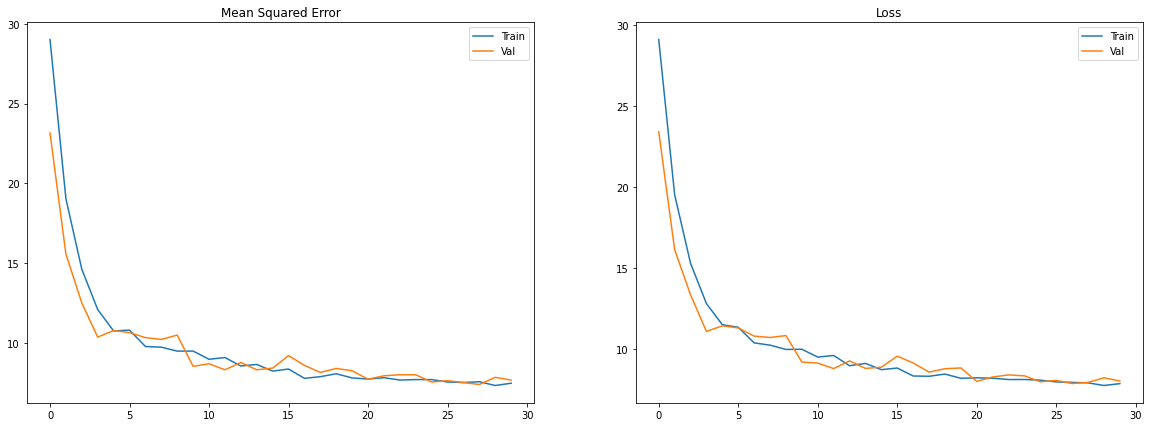

In [20]:
diabetes_model, history = build_diabetes_model(diabetes_train_ds, diabetes_val_ds, claim_feature_layer, epochs=30)

## Show Model Uncertainty Range with TF Probability

**Question 9**: Now that we have trained a model with TF Probability layers, we can extract the mean and standard deviation for each prediction. Please fill in the answer for the *m* and *s* variables below. The code for getting the predictions is provided for you below.

In [21]:
feature_list = student_categorical_col_list + student_numerical_col_list
diabetes_x_tst = dict(d_test[feature_list])
diabetes_yhat = diabetes_model(diabetes_x_tst)
preds = diabetes_model.predict(diabetes_test_ds);

In [22]:
from utils.student_utils import get_mean_std_from_preds
m, s = get_mean_std_from_preds(diabetes_yhat)

### Show prediction output

In [23]:
prob_outputs = {"pred": preds.flatten(),
                "actual_value": d_test['time_in_hospital'].values,
                "pred_mean": m.numpy().flatten(),
                "pred_std": s.numpy().flatten()}

prob_output_df = pd.DataFrame(prob_outputs)

In [24]:
prob_output_df.head()

,pred,actual_value,pred_mean,pred_std
0,2.405511,1.0,2.388775,0.701767
1,1.651800,3.0,2.817256,0.699634
2,4.650952,5.0,5.300058,0.700955
3,1.450381,2.0,5.040493,0.700378
4,1.961758,3.0,3.226540,0.700114


## Convert Regression Output to Classification Output for Patient Selection

**Question 10**: Given the output predictions, convert it to a binary label for whether the patient meets the time criteria or does not (HINT: use the mean prediction numpy array). The expected output is a numpy array with a 1 or 0 based off if the prediction meets or doesnt meet the criteria.

In [25]:
from utils.student_utils import get_student_binary_prediction
student_binary_prediction = get_student_binary_prediction(prob_output_df, 'pred_mean')

### Add Binary Prediction to Test Dataframe

Using the student_binary_prediction output that is a numpy array with binary labels, we can use this to add to a dataframe to better visualize and also to prepare the data for the Aequitas toolkit. The Aequitas toolkit requires that the predictions be mapped to a binary label for the predictions (called 'score' field) and the actual value (called 'label_value').

In [26]:
def add_pred_to_test(test_df, pred_np, demo_col_list):
    for c in demo_col_list:
        test_df[c] = test_df[c].astype(str)
    test_df['score'] = pred_np
    test_df['label_value'] = test_df['time_in_hospital'].apply(lambda x: 1 if x >=5 else 0)
    return test_df

pred_test_df = add_pred_to_test(d_test, student_binary_prediction, ['race', 'gender'])

In [27]:
pred_test_df[['patient_nbr', 'gender', 'race', 'time_in_hospital', 'score', 'label_value']].head()

,patient_nbr,gender,race,time_in_hospital,score,label_value
0,49726791,Female,AfricanAmerican,1.0,0,0
1,108662661,Female,Caucasian,3.0,0,0
2,107389323,Male,AfricanAmerican,5.0,1,1
3,22864131,Female,?,2.0,1,0
4,62718876,Female,AfricanAmerican,3.0,0,0


## Model Evaluation Metrics

**Question 11**: Now it is time to use the newly created binary labels in the 'pred_test_df' dataframe to evaluate the model with some common classification metrics. Please create a report summary of the performance of the model and be sure to give the ROC AUC, F1 score (weighted), class precision and recall scores. 

For the report please be sure to include the following three parts:
- With a non-technical audience in mind, explain the precision-recall tradeoff in regard to how you have optimized your model.

- What are some areas of improvement for future iterations?

In [28]:
def classification_metrics(pred_test_df):
    print('Precision ', round(precision_score(pred_test_df['label_value'], pred_test_df['score']),3))
    print('Recall ', round(recall_score(pred_test_df['label_value'], pred_test_df['score']),3))
    print('F1 Score ', round(f1_score(pred_test_df['label_value'], pred_test_df['score'], average='weighted'),3))
    print('ROC AUC ', round(roc_auc_score(pred_test_df['label_value'], pred_test_df['score']),3))

**Summary**

In [29]:
classification_metrics(pred_test_df)

Precision  0.745
Recall  0.469
F1 Score  0.716
ROC AUC  0.684


It is very challenging to have both precision and recall high at the same time. If we optimize the model to have high precision, most likely the recal will decrease. High precision means that most of our predictions of class 1 are correct, while high recall means that we correctly predicted as one class 1 most of true instances of that class. Precision-recall trade-off is the choice of minimizing either False Positives (FP) or False Negatives (FN):

![](images/precision-recall.png)

True Positive (TP) is the patient who stayed at the hospital at least 5 days and the model correctly predicted that. FP is the patient who stayed less than 5 days, but the model predicted that he stayed more than 5 days. FN is the oposite of FP - the patient who stayed longer than 5 days, but our model predicted that he stayed less than 5 days.

In this project, we would rather have high precision. We want to have low False Positives rate so that we administer the drug only to patients who stay at the hospital longer than 5 days, so that the administration of the drug is justified and meaningful. We care less about False Negatives - if we miss the patient who stays more than 5 days, we may just wait for another patient and it is less severe than starting aministering the drug to the person who leaves the hospital too soon.

Areas of improvement for future iterations may include lowering False Negatives - we would miss less patients who are eligible and the trial of the drug could have been shorter (or if the timelines are fixed we could have more patients tested).

## Evaluating Potential Model Biases with Aequitas Toolkit

### Prepare Data For Aequitas Bias Toolkit

Using the gender and race fields, we will prepare the data for the Aequitas Toolkit.

In [30]:
from aequitas.preprocessing import preprocess_input_df
from aequitas.group import Group
from aequitas.plotting import Plot
from aequitas.bias import Bias
from aequitas.fairness import Fairness

ae_subset_df = pred_test_df[['race', 'gender', 'score', 'label_value']]
ae_df, _ = preprocess_input_df(ae_subset_df)
g = Group()
xtab, _ = g.get_crosstabs(ae_df)
absolute_metrics = g.list_absolute_metrics(xtab)
clean_xtab = xtab.fillna(-1)
aqp = Plot()
b = Bias()

/home/marta/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


### Reference Group Selection

Below we have chosen the reference group for our analysis but feel free to select another one.

In [31]:
# test reference group with Caucasian Male
bdf = b.get_disparity_predefined_groups(clean_xtab, 
                                        original_df=ae_df, 
                                        ref_groups_dict={'race':'Caucasian', 'gender':'Male'},
                                        alpha=0.05, 
                                        check_significance=False)

f = Fairness()
fdf = f.get_group_value_fairness(bdf)

get_disparity_predefined_group()


### Race and Gender Bias Analysis for Patient Selection

**Question 12**: For the gender and race fields, please plot two metrics that are important for patient selection below and state whether there is a significant bias in your model across any of the groups along with justification for your statement.

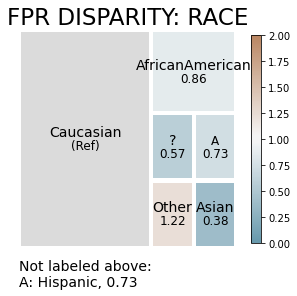

In [32]:
# Plot two metrics

# Is there significant bias in your model for either race or gender?

fpr_disparity = aqp.plot_disparity(bdf, group_metric='fpr_disparity', attribute_name='race')

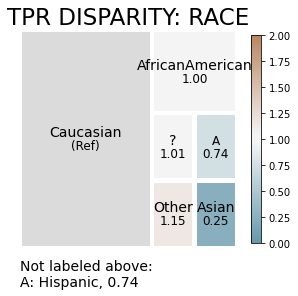

In [33]:
tpr_disparity = aqp.plot_disparity(bdf, group_metric='tpr_disparity', attribute_name='race')

There is a bias towards Asian race in both False Positives Rate and True Positives Rate to the reference group - Caucasian. The ratios of Asian FPR and TPR compared to the reference group are low. Also, in case of FPR we see some bias toward other races as well - the ratios are < 0.8 compared to the reference group.

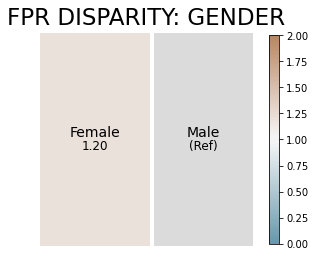

In [34]:
fpr_disparity = aqp.plot_disparity(bdf, group_metric='fpr_disparity', attribute_name='gender')

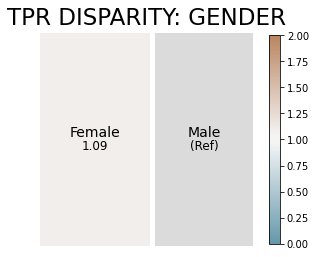

In [35]:
tpr_disparity = aqp.plot_disparity(bdf, group_metric='tpr_disparity', attribute_name='gender')

There is no significant bias in regard to gender. Both genders have similar ratios.

### Fairness Analysis Example - Relative to a Reference Group

**Question 13**: Earlier we defined our reference group and then calculated disparity metrics relative to this grouping. Please provide a visualization of the fairness evaluation for this reference group and analyze whether there is disparity.

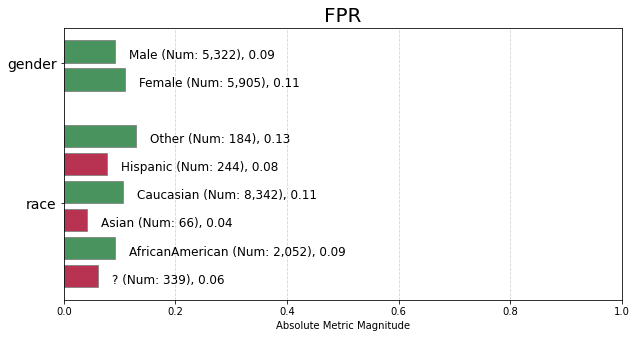

In [36]:
# Reference group fairness plot

fpr_fairness = aqp.plot_fairness_group(fdf, group_metric='fpr', title=True)

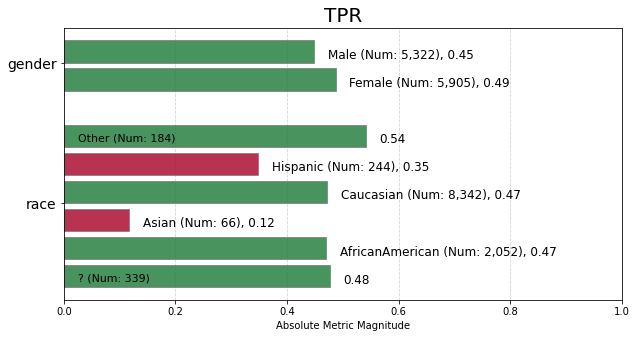

In [37]:
tpr_fairness = aqp.plot_fairness_group(fdf, group_metric='tpr', title=True)

We see that there is some unfairness for Asian and Hispanic race in regard to False Positive Rate and True Positive Rate. Also, in regard to FPR unknown race also face some unfairness.